[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/qbeer/patho-segmentation-unet/blob/master/segmentation.ipynb)

In [ ]:
!git clone https://github.com/qbeer/patho-segmentation-unet
!cp -a patho-segmentation-unet/* .

In [1]:
from patho import Model, UNET, DataLoader
import os
import torch
import numpy as np
from PIL import Image

In [2]:
net = UNET()
net.make_parallel()

model = Model(net)

In [3]:
data_loader = DataLoader("patho/data", "resized_images",
                         "resized_masks", batch_size=2).getInstance()

In [19]:
model.train(data_loader, EPOCH=5)

[1,    10] loss: 2.764
[1,    20] loss: 2.740
[1,    30] loss: 2.991
[1,    40] loss: 2.912
[1,    50] loss: 2.976
[1,    60] loss: 2.598
[1,    70] loss: 2.793
[1,    80] loss: 2.899
[1,    90] loss: 3.171
[1,   100] loss: 2.638
[1,   110] loss: 2.826
[1,   120] loss: 2.761
Average batch loss on epoch end : 2.83937
[2,    10] loss: 2.814
[2,    20] loss: 3.103
[2,    30] loss: 2.788
[2,    40] loss: 2.749
[2,    50] loss: 2.734
[2,    60] loss: 2.737
[2,    70] loss: 2.861
[2,    80] loss: 2.868
[2,    90] loss: 2.997
[2,   100] loss: 3.078
[2,   110] loss: 2.623
[2,   120] loss: 2.918
Average batch loss on epoch end : 2.87695
[3,    10] loss: 2.366
[3,    20] loss: 3.087
[3,    30] loss: 2.763
[3,    40] loss: 2.950
[3,    50] loss: 2.714
[3,    60] loss: 2.763
[3,    70] loss: 3.469
[3,    80] loss: 2.556
[3,    90] loss: 2.996
[3,   100] loss: 2.845
[3,   110] loss: 2.889
[3,   120] loss: 3.008
Average batch loss on epoch end : 2.88376
[4,    10] loss: 3.057
[4,    20] loss: 2.513


In [20]:
for imgs, masks in data_loader:
    predicted_masks = model.net(imgs).cpu().detach().numpy()
    imgs, masks = imgs.cpu().detach().numpy(), masks.cpu().detach().numpy()
    break
    
print(imgs.shape, masks.shape)
print(np.min(predicted_masks[0]), np.max(predicted_masks[0]))
print(np.min(masks[0]), np.max(masks[0]))

(2, 3, 572, 572) (2, 1, 388, 388)
0.0036956228 0.90217674
0.0 1.0


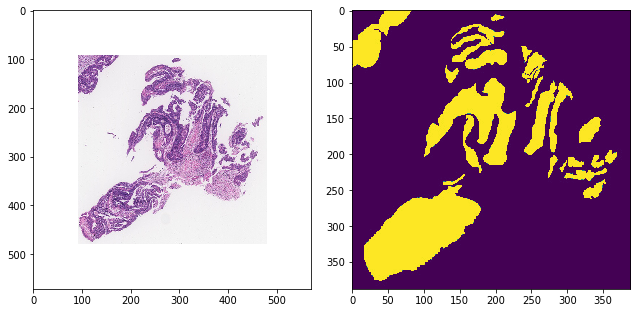

In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(9, 6))

axes[0].imshow(imgs[0].transpose((1, 2, 0)))
axes[1].imshow(masks[0].transpose((1, 2, 0)).reshape(388, 388))

fig.tight_layout()
plt.show()

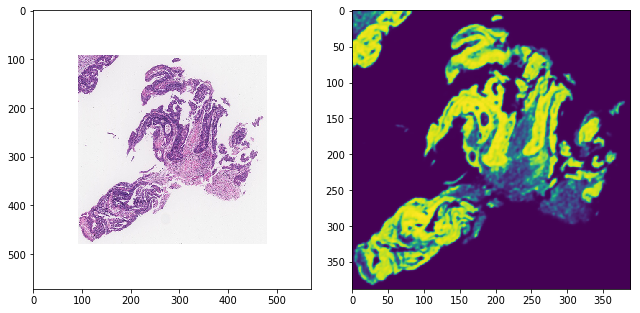

In [22]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(9, 6))

axes[0].imshow(imgs[0].transpose((1, 2, 0)))
axes[1].imshow(predicted_masks[0].transpose((1, 2, 0)).reshape(388, 388))

fig.tight_layout()
plt.show()

In [23]:
predicted_masks[predicted_masks >= 0.5] = 1.
predicted_masks[predicted_masks < 0.5] = 0.

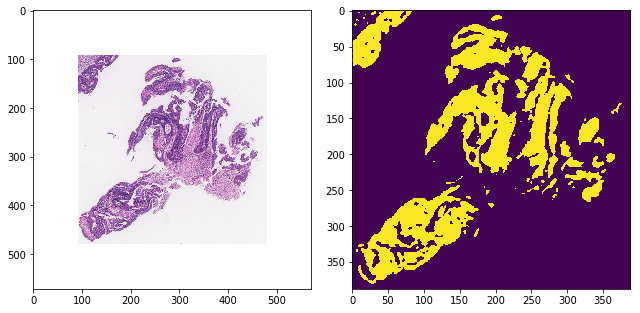

In [24]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(9, 6))

axes[0].imshow(imgs[0].transpose((1, 2, 0)))
axes[1].imshow(predicted_masks[0].transpose((1, 2, 0)).reshape(388, 388))

fig.tight_layout()
plt.show()